In [33]:
import pandas as pd
import numpy as np
import glob
import json
import re

In [34]:
da_encoder = {'Instruction':2, 'Probing':0, 'Supplement':4, 'Interpretation':3,
       'All Utility':5, 'Confronting':1}
dialogue_acts_decode ={0:"probing", 1:"confronting", 2:"instruction", 3:"interpretation",
                       4:"supplement",
                       5:"utility"}

index = ['probing', 'confronting', 'instruction', 'interpretation', 'supplement', 'utility']
col = ['informational', 'coordinative', 'social']
motive_decode = {"i": "informational", "s": "social", "c": "coordinative"}
da_decode = {'prob': "Probing", 'conf': "Confronting", 'inst': "Instruction", 'inte': "Interpretation", 'supp': 'Supplement', 'util': 'Utility'}

In [35]:
def load_results():
    output = {}
    result_files = glob.glob("./mod_result/*.csv")
    dfs = []
    for r in result_files:
        session_id = r.split("/")[-1].replace("_pro.csv", "")
        df = pd.read_csv(r, index_col = 0)
        output[session_id] = df
    return output
        

In [36]:
def find_intercepted_interval_indexes(range_tuple, intervals):
    i, j = range_tuple
    intercepted_indexes = []

    for index, interval in enumerate(intervals):
        start, end = interval
        # Check if intervals intersect
        if start <= j and end >= i:
            intercepted_indexes.append(index)

    return intercepted_indexes

In [37]:
def generate_intervals(n, m):
    interval_size = n // m
    intervals = []
    for i in range(m):
        start = i * interval_size
        end = (i + 1) * interval_size - 1
        if i == m - 1:  # Adjust the last interval to include the remainder
            end = n - 1
        intervals.append((start, end))
    return intervals

In [38]:
def aggregate_utterance_labels(results):
    inter_utterance_sequence = []
    intra_utterance_sequence = []
    for session_id, rdf in results.items():
        episode_inter_utterance_sequence = []
        episode_intra_utterance_sequence = []
        total_tokens_count = np.sum([len(str(s).split(" ")) for s in rdf["text"].dropna().tolist()])
        token_count_intervals = generate_intervals(total_tokens_count, 40)

        prior_mod_cache = {
                    "speaker": "",
                    "role": "",
                    "index": -1
                }
        accumulate_tokens_count = 0

        turn_ids = list(rdf.turn_index.unique())
    
        for i, t_id in enumerate(turn_ids):
            sents = rdf[rdf.turn_index == t_id]
            first_sent = sents.iloc[0]
            speaker = first_sent.speaker
            role = first_sent.role
            text = " ".join(sents.text)
            tokens_count = len(text.split(" "))

            interval_index = find_intercepted_interval_indexes((accumulate_tokens_count, accumulate_tokens_count+tokens_count), token_count_intervals)

            accumulate_tokens_count += tokens_count



            if role == "moderator":
                das = "-".join(list(sents["dialogue_act"].unique()))
                motives = "".join(sorted([m[0] for m in ["informational", "social", "coordinative"] if any(sents[m + " motive"])]))

                cur_utt_info = {"title": session_id, "speaker": speaker, "text": text, "sentence_count": len(sents),
                                        "role": role, "interval_index": interval_index, "count": tokens_count,
                                "labels":{"da": das, "m": motives}}
                
                episode_intra_utterance_sequence.append([{"title": session_id, "speaker": speaker, "text": s.text,
                                        "role": role, "labels":{"da": da_encoder[s.dialogue_act], "m": "".join([m[0] for m in ["informational", "social", "coordinative"] if s[m + " motive"]])}} for i, s in sents.iterrows()])

            else:
                label = "rott."
                if role == prior_mod_cache["role"]:
                    if speaker == prior_mod_cache["speaker"]:
                        label = "cont."

                cur_utt_info = {"title": session_id, "speaker": speaker, "text": text, "sentence_count": len(sents),
                                        "role": role, "interval_index": interval_index, "count": tokens_count, "labels":{"transition": label}}

                prior_mod_cache["speaker"] = speaker
                prior_mod_cache["role"] = role
                prior_mod_cache["index"] = i


            episode_inter_utterance_sequence.append(cur_utt_info)

        inter_utterance_sequence.append(episode_inter_utterance_sequence)
        intra_utterance_sequence.append(episode_intra_utterance_sequence)
    return inter_utterance_sequence, intra_utterance_sequence

In [39]:
def get_motive_dialogue_act_matrix(label_sequence, index=None, col=None, add_total=True, normalise=True):
    items = []
    labels_count = {"da": [0, 0, 0, 0, 0, 0], "m": [0, 0, 0], "total": 0}
    for sents in label_sequence:
        for sent in sents:
            if "transition" in sent["labels"]:
                continue
            labels_count["total"] += 1
            dialogue_act, motives = sent["labels"]["da"], sent["labels"]["m"]
            try:
                labels_count["da"][int(dialogue_act)] += 1
            except Exception as e:
                dialogue_act = str(int(float(dialogue_act)))
                labels_count["da"][int(dialogue_act)] += 1
            if motives:
                for m in motives:
                    m_index = "ics".index(m)
                    labels_count["m"][m_index] += 1
                    items.append((dialogue_acts_decode[dialogue_act], motive_decode[m]))

    if not index:
        first_dim = [item[0] for item in items]
        unique_first_dim = sorted(set(first_dim))
        index = unique_first_dim

    if not col:
        second_dim = [item[1] for item in items]
        unique_second_dim = sorted(set(second_dim))
        col = unique_second_dim

    # Step 2: Count Co-occurrences
    co_occurrence_counts = pd.DataFrame(0, index=index, columns=col)

    for item in items:
        co_occurrence_counts.at[item[0], item[1]] += 1

    co_occurrence_counts = co_occurrence_counts[[motive_decode['i'], motive_decode['c'], motive_decode['s']]]
    co_occurrence_counts.columns = ["IM", "CM", "SM"]
    co_occurrence_counts = co_occurrence_counts.T
    if normalise:
        co_occurrence_counts = co_occurrence_counts.div(labels_count['m'], axis=0)
        co_occurrence_counts = co_occurrence_counts.round(4)
        
    co_occurrence_counts = co_occurrence_counts.fillna(0)
    # co_occurrence_counts["total"] = [c / labels_count['total'] for c in labels_count['da']]
    if add_total:
        if normalise:
            co_occurrence_counts["total"] = [c /  labels_count['total'] for c in labels_count['m'] ]
            dialogue_act_count = [c / labels_count['total'] for c in labels_count['da']]
        else:
            co_occurrence_counts["total"] = [c for c in labels_count['m'] ]
            dialogue_act_count = [c for c in labels_count['da']]
        last_row = pd.DataFrame([dialogue_act_count+ [labels_count['total']]], columns=co_occurrence_counts.columns)
        last_row.index = ["total"]
        co_occurrence_counts = pd.concat([co_occurrence_counts, last_row])

    co_occurrence_counts.columns = [re.sub('[^A-Za-z]+', '', c)[:4] if c != "total" else "total" for c in
                                    co_occurrence_counts.columns]

    return co_occurrence_counts, labels_count

In [40]:
def get_motive_dialogue_act_matrix_episode_breakdown(label_sequence, index=None, col=None, normalise=True):
    eps_sqs_dict = {}
    eps_dfs = []
    eps_label_counts = {}
    for seq in label_sequence:
        eps = seq[0][0]["title"]
        eps_sqs_dict[eps] = seq

    for eps, seqs in eps_sqs_dict.items():
        co_occurrence_counts, labels_count = get_motive_dialogue_act_matrix(seqs, index, col, add_total=True, normalise=normalise)
        if co_occurrence_counts.isnull().values.any():
            print("DataFrame contains NaN values.")
        eps_dfs.append(co_occurrence_counts)
        eps_label_counts[eps] = labels_count

    # Stack the DataFrames into a 3D array (n, rows, cols)
    array_3d = np.array([df.values for df in eps_dfs])

    if normalise:
        # Calculate the means and stds for each cell
        mean_array = np.mean(array_3d, axis=0)
        # std_array = np.std(array_3d, axis=0)
    
        # Create DataFrames from the results
        mean_df = pd.DataFrame(mean_array, columns=eps_dfs[0].columns, index=eps_dfs[0].index)
        # std_df = pd.DataFrame(std_array, columns=eps_dfs[0].columns, index=eps_dfs[0].index)
        
        return mean_df, eps_label_counts
    else:
        # Calculate the means and stds for each cell
        sum_array = np.sum(array_3d, axis=0)
        # std_array = np.std(array_3d, axis=0)
    
        # Create DataFrames from the results
        sum_df = pd.DataFrame(sum_array, columns=eps_dfs[0].columns, index=eps_dfs[0].index)
        # std_df = pd.DataFrame(std_array, columns=eps_dfs[0].columns, index=eps_dfs[0].index)
        return sum_df, eps_label_counts

In [41]:
results = load_results()

In [42]:
rdf = pd.concat([df for eps, df in results.items()])

In [43]:
inter_utterance_sequence, intra_utterance_sequence = aggregate_utterance_labels(results)

In [44]:
sum_df, eps_label_counts = get_motive_dialogue_act_matrix_episode_breakdown(intra_utterance_sequence, index=index, col=col, normalise=False)

In [45]:
sum_df

,prob,conf,inst,inte,supp,util,total
IM,865,17,11,285,1197,23,2398
CM,37,2,125,6,30,16,216
SM,70,3,8,75,389,312,857
total,880,19,129,334,1494,413,3269


In [14]:
mean_df, eps_label_counts = get_motive_dialogue_act_matrix_episode_breakdown(intra_utterance_sequence, index=index, col=col, normalise=True)
mean_df

,prob,conf,inst,inte,supp,util,total
IM,0.365300,0.007590,0.004820,0.117670,0.495470,0.009170,0.736452
CM,0.169510,0.005710,0.574370,0.030390,0.140010,0.080010,0.068427
SM,0.085820,0.002430,0.010770,0.078340,0.429040,0.393590,0.259770
total,0.272699,0.006219,0.041857,0.100704,0.453698,0.124822,326.900000


# Topic modelling

In [15]:
import os

# Set TOKENIZERS_PARALLELISM to "false" or "true" as needed
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [16]:
# from umap import UMAP
from bertopic import BERTopic
import pandas as pd
import json
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import spacy_transformers
import string
from spacy import displacy
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from hdbscan import HDBSCAN
import random


# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load the English language model
nlp = spacy.load('en_core_web_trf')
stopwords = set(stopwords.words('english'))

/Users/mingbin/anaconda3/envs/bertopic/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/mingbin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mingbin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

def get_topic_coherence_score(topic_model, sentences):

    # Get topics and their corresponding words
    topics = topic_model.get_topics()
    texts = [doc.split() for doc in sentences]
    
    # Create a dictionary and corpus for coherence calculation
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Get topic words
    topic_words = [[word for word, _ in topic_model.get_topic(topic_num)] for topic_num in topic_model.get_topic_info().Topic.unique() if topic_num != -1]
    
    # Calculate coherence
    coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

In [18]:
speakers_strings = set()
for t, df in results.items():
    df_speakers = df.speaker.unique()
    df_speakers = df_speakers.tolist()
    for n in df_speakers:
        name_strings = n.lower().split(" ")
        speakers_strings.update(name_strings)
speakers_strings = list(speakers_strings)
speakers_strings.extend(["felicity", "felicitys", "felicity", "moderator", "social", "'s"])

In [19]:
topic_words = ["romance", "romantic", "relationship", "modern", "society", "boss", "bosses", "employment", "work", "job",
               "stress", "cultural", "ai", "future", "god", "ghost", "superstitions", "superstition"]

In [20]:
def get_shorten_index(text):
    shorten_index = len(text.split(" "))

    index_comma = 0
    indexes_comma = [i for i, c in enumerate(text) if c == ","]
    for i in indexes_comma:
        if len(text[:i].split(" ")) >= 10:
            index_comma = i
            break
    
    before_co_str = text[:index_comma]
    before_co_tk_count = len(before_co_str.split(" "))

    index_stop = 0
    indexes_stop = [i for i, c in enumerate(text) if c == "."]
    for i in indexes_stop:
        if len(text[:i].split(" ")) >= 10:
            index_stop = i
            break
            
    before_stp_str = text[:index_stop]
    before_stp_tk_count = len(before_stp_str.split(" "))
    
    max_tk_count = max(before_co_tk_count, before_stp_tk_count)
    min_tk_count = min(before_co_tk_count, before_stp_tk_count)
    
    if max_tk_count < 10:
        shorten_index =  10
    elif min_tk_count >= 10:
        shorten_index =  min_tk_count
    else:
        for c in [before_co_tk_count, before_stp_tk_count]:
            if c >= 10:
                shorten_index = c

    return " ".join(text.split(" ")[:shorten_index])


In [21]:
def extract_key_reason(text):
    doc = nlp(text)
    root_toks = []
    for token in doc:
        if token.dep_ == "ROOT":
           root_toks.append(token)
            
    sents = []
    for rtk in root_toks:
        sent_toks = []
        sent_toks.append(rtk)
        for child in rtk.children:
            if child.dep_ == "dobj":
                for t in child.subtree:
                   sent_toks.append(t)
            
            # if child.dep_ in ["nsubj", "dobj"]:
            #     sent_toks.append(child)
                # for t in child.subtree:
                #    sent_toks.append(t)
    
        sent_toks = sorted(sent_toks, key=lambda token: token.i)
        sents.append(" ".join([t.text for t in sent_toks]))

    return sents
    

In [22]:
def remove_person_names(text):
    doc = nlp(text)
    # Replace each person name with an empty string
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            text = text.replace(ent.text, '')
    return text

In [23]:
def preprocess(text):
    # text = get_shorten_index(text)
    text = extract_key_reason(text)[0]
    text = remove_person_names(text)
    tokens = text.split(" ")
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in speakers_strings]
    tokens = [t for t in tokens if t not in topic_words]
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [t for t in tokens if t not in stopwords]

    text = " ".join(tokens)
    return text

In [24]:
def print_top_freq_words(sentences):
    # Initialize an empty list to hold all tokens
    all_tokens = []
    
    for sentence in sentences:
        # Tokenize the sentence
        tokens = sentence.split(" ")
        # Convert tokens to lowerc
        all_tokens.extend(tokens)
    
    # Count the frequency of each unique token
    token_counts = Counter(all_tokens)
    
    # Get the top N tokens
    top_n = 20
    most_common_tokens = token_counts.most_common(top_n)
    
    # Display the results
    print(f"Top {top_n} unique tokens:")
    for token, count in most_common_tokens:
        print(f"{token}: {count}")


In [115]:
def show_topics_example(topic_model, topics, reasons, origins):
    topic_info = topic_model.get_topic_info()

    topics_examples = {}

    for i, t in enumerate(topics):
        if t not in topics_examples:
            topics_examples[t] = []
        topics_examples[t].append((reasons[i], origins[i]))

    for i, r in topic_info.iterrows():
        print(f"Topic index {r.Topic}")
        print(f"Topic count {r.Count}")
        print(f"Topic name {r.Name}")
        print(f"Rep words: {r.Representation}")
        print("Rep sents: \n")
        # topics_example[r.Topic] = []
        examples = random.sample(topics_examples[r.Topic], 4)

        for s in examples:
            print("-" * 40)
            print("origina: " + s[1] + "\n")
            print("reason: " + s[0] + "\n")

        print("*"*60)

In [58]:
def model_topics(sentences, umap_n_neighbor, umap_min_dist, n_clusters):
    umap_model = UMAP(n_neighbors=umap_n_neighbor, n_components=5, min_dist=umap_min_dist, metric='cosine')
    cluster_model = KMeans(n_clusters=n_clusters)
    topic_model = BERTopic(umap_model=umap_model, embedding_model="allenai-specter",
                                       hdbscan_model=cluster_model, calculate_probabilities=True)
    topics, probabilities = topic_model.fit_transform(sentences)
    # Calculate coherence or another metric
    print(f"n_clusters={n_clusters}, umap_n_neighbor={umap_n_neighbor}; umap_min_dists={umap_min_dist}")
    coherence = get_topic_coherence_score(topic_model, sentences)
    print(f"Coherence={coherence}")
    return topic_model, topics, coherence

In [27]:
def find_best_topics(sentences):
    best_score = -1
    best_params = {}
    # Define ranges for hyperparameters
    umap_n_neighbors = [5, 10, 30]
    umap_min_dists = [0.0, 0.3, 0.5]
    n_clusterses = [2, 3, 4, 5]
    
    for umap_n_neighbor in umap_n_neighbors:
        for umap_min_dist in umap_min_dists:
            for n_clusters in n_clusterses:
                incomplete = True
                while incomplete:
                    try:
                        topic_model, topics, coherence = model_topics(sentences, umap_n_neighbor, umap_min_dist, n_clusters)
                        incomplete = False
                    except Exception as e:
                        print(e)
                # Update best score and parameters
                if coherence > best_score:
                    best_score = coherence
                    best_params = {
                        'n_clusters': n_clusters,
                        'umap_min_dist': umap_min_dist,
                        'umap_n_neighbor': umap_n_neighbor
                    }
    return best_params

## Identify prominent action x motivation pairs

In [28]:

remained_cats = {}
topic_modeling_target = []

for i in mean_df.index:
    for c in mean_df.columns:
        if c == "total" or i == "total":
            continue
        real_prob = round(mean_df.at[i, c] * mean_df.at[i, 'total'], 3)
        if real_prob >= 0.025:
            print("\n")
            print(f"index: {i}, col: {c}")
            print(f"count: {round(sum_df.at[i, c], 3)}")
            print(f"transition prob: {round(mean_df.at[i, c], 3)}")
            print(f"real prob: {real_prob}")

            remained_cats[i + "-" + c] = {"data":rdf[(rdf["dialogue_act"] == da_decode[c]) & (rdf[motive_decode[i[0].lower()] + " motive"] == True)],
                                          "prob": real_prob,
                                          "count": round(sum_df.at[i, c], 3)}
            if real_prob > 0.1:
                topic_modeling_target.append(i + "-" + c)
                print("add for topic modelling!")



index: IM, col: prob
count: 865
transition prob: 0.365
real prob: 0.269
add for topic modelling!


index: IM, col: inte
count: 285
transition prob: 0.118
real prob: 0.087


index: IM, col: supp
count: 1197
transition prob: 0.495
real prob: 0.365
add for topic modelling!


index: CM, col: inst
count: 125
transition prob: 0.574
real prob: 0.039


index: SM, col: supp
count: 389
transition prob: 0.429
real prob: 0.111
add for topic modelling!


index: SM, col: util
count: 312
transition prob: 0.394
real prob: 0.102
add for topic modelling!


In [46]:
topic_modeling_target

['IM-prob', 'IM-supp', 'SM-supp', 'SM-util']

## Topic modelling highly frequent categories

In [ ]:
result_dic = {}
for target in topic_modeling_target:
    print("*" * 70)
    print(f"target category: {target}")
    subdf = remained_cats[target]["data"]
    sentences = subdf["reason"].apply(preprocess).tolist()
    print_top_freq_words(sentences)
    print("Topic modelling params search!")
    best_params = find_best_topics(sentences)
    topic_model, topics, coherence = model_topics(sentences, best_params['umap_n_neighbor'],
                                                  best_params['umap_min_dist'], best_params['n_clusters'])
    topic_model.visualize_barchart()
    show_topics_example(topic_model, topics, subdf["reason"].tolist())
    result_dic[target] = {"topic_model":topic_model, "topics":topics, "coherence": coherence}
    


In [ ]:
topic_model, topics, coherence = model_topics(sentences, 10, 0.0, 3)

show_topics_example(topic_model, topics, subdf["reason"].tolist())
result_dic[target] = {"topic_model":topic_model, "topics":topics, "coherence": coherence}

In [ ]:
topic_model.visualize_barchart()

## IM-prob

In [117]:
target = "IM-prob"
subdf = remained_cats[target]["data"]

In [118]:
sentences = subdf["reason"].apply(preprocess).tolist()

In [125]:
origins = subdf["text"].tolist()

In [120]:
topic_model, topics, coherence = model_topics(sentences, 5, 0.0, 3)

n_clusters=3, umap_n_neighbor=5; umap_min_dists=0.0
Coherence=0.729665719457317


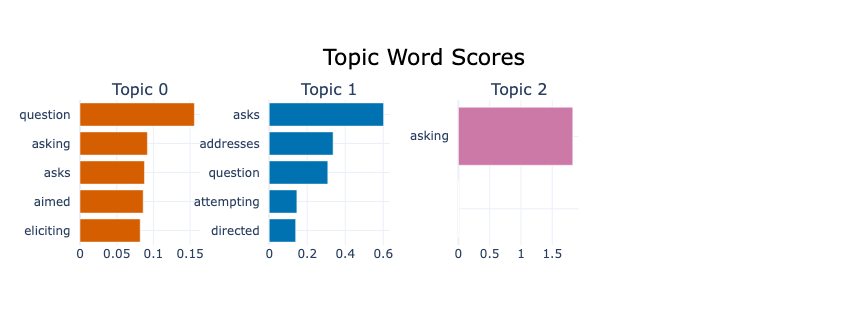

In [122]:
topic_model.visualize_barchart()

In [126]:
show_topics_example(topic_model, topics, subdf["reason"].tolist(), origins)

Topic index 0
Topic count 574
Topic name 0_question_asking_asks_aimed
Rep words: ['question', 'asking', 'asks', 'aimed', 'eliciting', 'information', 'participants', 'poses', 'regarding', 'topic']
Rep sents: 

----------------------------------------
origina: Anyone else who want to share their thought or opinion about why they what's the purpose of relationship for them?

reason: The moderator is seeking contributions from participants by asking an open-ended question, which aims to elicit their thoughts or opinions on the purpose of relationships, advancing the informational content of the discussion.

----------------------------------------
origina: Questions.

reason: The moderator issues a brief elicitation, 'Questions,' targeting Amy, to prompt further explanation or clarification on the 'tomato car management' she mentioned, seeking more relevant information on the topic discussed.

----------------------------------------
origina: What is that? Do you?

reason: The moderator, B

## IM-supp

In [81]:
target = "IM-supp"
subdf = remained_cats[target]["data"]
original_sents = subdf["text"].tolist()
sentences = subdf["reason"].apply(preprocess).tolist()

In [105]:
topic_model, topics, coherence = model_topics(sentences, 10, 0.5, 3)

n_clusters=3, umap_n_neighbor=10; umap_min_dists=0.5
Coherence=0.45380130850054295


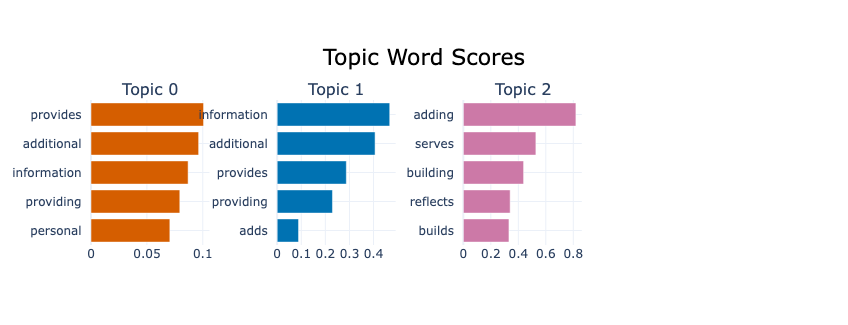

In [107]:
topic_model.visualize_barchart()

In [116]:
show_topics_example(topic_model, topics, subdf["reason"].tolist(), original_sents)

Topic index 0
Topic count 927
Topic name 0_provides_additional_information_providing
Rep words: ['provides', 'additional', 'information', 'providing', 'personal', 'discussion', 'context', 'related', 'insight', 'experience']
Rep sents: 

----------------------------------------
origina: I'm talking about housework so.

reason: The moderator provides additional information about what the previous discussion was focusing on, specifically clarifying that the earlier talk was about housework. This adds context and aids in understanding the ongoing discussion, which is why it is categorized as 'informational motive' and 'Supplement.' The information is directed to everyone participating in the discussion to ensure clarity.

----------------------------------------
origina: The type, the the time feel much, much faster, just like, you know, because our relationships are already stabilized, and there were nothing really.

reason: The moderator is elaborating on a personal example related to ti

## SM-supp

In [129]:
target = "SM-supp"
subdf = remained_cats[target]["data"]
original_sents = subdf["text"].tolist()
sentences = subdf["reason"].apply(preprocess).tolist()

In [156]:
topic_model, topics, coherence = model_topics(sentences, 30, 0.1, 4)

n_clusters=4, umap_n_neighbor=30; umap_min_dists=0.1
Coherence=0.4749656588345187


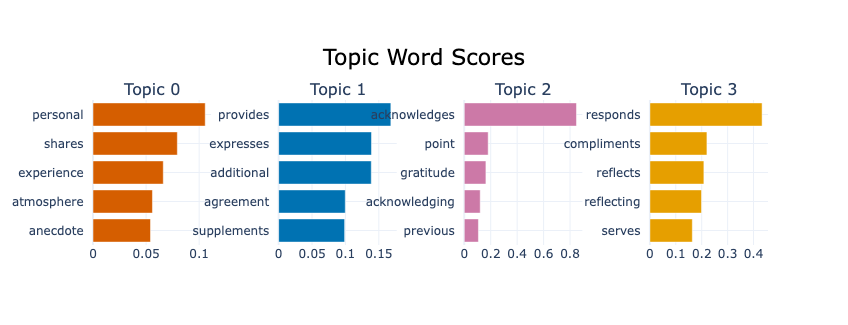

In [157]:
topic_model.visualize_barchart()

In [ ]:
show_topics_example(topic_model, topics, subdf["reason"].tolist(), original_sents)

## SM-util

In [181]:
target = 'SM-util'
subdf = rdf[(rdf["dialogue_act"] == "All Utility") & (rdf["social motive"] == True)]
original_sents = subdf["text"].tolist()
sentences = subdf["reason"].apply(preprocess).tolist()

In [195]:
topic_model, topics, coherence = model_topics(sentences, 30, 0.5, 5)

n_clusters=5, umap_n_neighbor=30; umap_min_dists=0.5
Coherence=0.4146657998854402


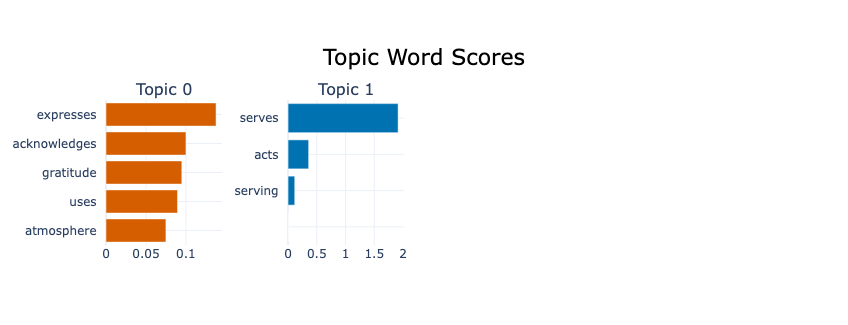

In [193]:
topic_model.visualize_barchart()

In [194]:
show_topics_example(topic_model, topics, subdf["reason"].tolist(), original_sents)

Topic index 0
Topic count 261
Topic name 0_expresses_acknowledges_gratitude_uses
Rep words: ['expresses', 'acknowledges', 'gratitude', 'uses', 'atmosphere', 'appears', 'towards', 'response', 'information', 'acknowledging']
Rep sents: 

----------------------------------------
origina: Yeah.

reason: The moderator's response 'Yeah.' is minimal and serves as back-channelling to show he is listening and acknowledging Felicity's statements without attempting to drive the conversation forward or alter its course.

----------------------------------------
origina: Goodbye!

reason: The moderator is saying goodbye, which is a social gesture aimed at enhancing the social atmosphere. The act is a general utility speech act as it doesn't attempt to elicit information, instruct behavior, or provide insight from earlier dialogue. It is directed at the group as a whole, as is typical in a closing statement.

----------------------------------------
origina: There.

reason: The target sentence 'Ther